### UNSEEN + analogs ###

Using UNSEEN method combined with observed analogs to get representative hourly wind speeds given the daily 10m wind speed/NAO/MSLP from the model.

Stringer, Thornton, and Knight (2020) - https://journals.ametsoc.org/view/journals/apme/59/2/jamc-d-19-0094.1.xml

Steps:

1. Using the DePreSys output which has been bias corrected to ERA5 (for sfcWind, msl).
2. Grab the daily (bias corrected) daily 10m wind field and psl field (+ NAO)
3. Find the absolute differences between the model day and all days from ERA5
4. Select the day from ERA5 with the lowest absolute differences for one field/3 fields.
5. Pass the bias corrected 100m wind field through the CLEARHEADS model.
6. Get the hourly time series of onshore/offshore wind capacity factors for the ERA5 day.
7. Repeat for all of the days of the DePreSys data.

In [1]:
# Import local modules
import os
import sys
import time
import glob

# Import external modules
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import iris

# Import tqdm for progress bar
from tqdm import tqdm

# Specific imports
from ncdata.iris_xarray import cubes_to_xarray, cubes_from_xarray

In [2]:
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import select_gridbox

In [3]:
# Set up the path to the 10m wind speed data from ERA5
# test with a shorter file
ERA5_dir = "/gws/nopw/j04/canari/users/benhutch/ERA5"
fname_test = "ERA5_msl_daily_1960_2020_daymean.nc" # msl data now

# Set up the path to the model 10m wind speed data
model_dir = "/work/scratch-nopw2/benhutch/test_nc/"
fname_test_month = "psl_bias_correction_HadGEM3-GC31-MM_lead1_month11_init1960-1960.nc"

In [4]:
# import dictionaries
sys.path.append("/home/users/benhutch/unseen_functions")

import unseen_dictionaries as udicts

Load the bias corrected model data and find the first day for the first ensemble member.

In [5]:
# Load the model data
model_data = xr.open_dataset(os.path.join(model_dir, fname_test_month))

In [6]:
model_data

<xarray.Dataset>
Dimensions:                        (lead: 30, init: 1, member: 10, lat: 324,
                                    lon: 432)
Coordinates:
  * lead                           (lead) int64 1 2 3 4 5 6 ... 26 27 28 29 30
  * init                           (init) int64 1960
  * member                         (member) object 'r5i1p1f2' ... 'r10i1p1f2'
  * lat                            (lat) float64 -89.72 -89.17 ... 89.17 89.72
  * lon                            (lon) float64 -179.6 -178.8 ... 178.7 179.6
Data variables:
    __xarray_dataarray_variable__  (init, member, lead, lat, lon) float64 ...

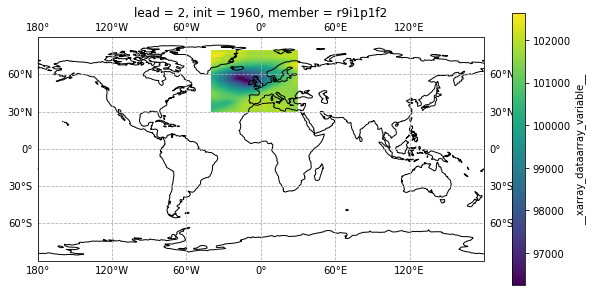

In [7]:
# plot the model data
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# include coastlines
ax.coastlines()

# include the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

# plot the data
model_data["__xarray_dataarray_variable__"].isel(member=1, lead=1).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [8]:
print(udicts.eu_grid)

{'lon1': -40, 'lon2': 30, 'lat1': 30, 'lat2': 80}


In [9]:
# # Apply the mask for the european domain
# model_data = select_gridbox(
#     ds=model_data,
#     grid=udicts.eu_grid,
#     calc_mean=False,
# )

In [10]:
model_data

<xarray.Dataset>
Dimensions:                        (lead: 30, init: 1, member: 10, lat: 324,
                                    lon: 432)
Coordinates:
  * lead                           (lead) int64 1 2 3 4 5 6 ... 26 27 28 29 30
  * init                           (init) int64 1960
  * member                         (member) object 'r5i1p1f2' ... 'r10i1p1f2'
  * lat                            (lat) float64 -89.72 -89.17 ... 89.17 89.72
  * lon                            (lon) float64 -179.6 -178.8 ... 178.7 179.6
Data variables:
    __xarray_dataarray_variable__  (init, member, lead, lat, lon) float64 ...

In [11]:
# load the observed data
obs_data = xr.open_dataset(os.path.join(ERA5_dir, fname_test))

In [12]:
obs_data

<xarray.Dataset>
Dimensions:    (time: 22281, bnds: 2, longitude: 304, latitude: 214)
Coordinates:
  * time       (time) datetime64[ns] 1960-01-01T11:00:00 ... 2020-12-31T11:00:00
  * longitude  (longitude) float32 -45.0 -44.72 -44.44 ... 39.66 39.94 40.22
  * latitude   (latitude) float32 89.78 89.51 89.23 88.95 ... 30.49 30.21 29.93
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    msl        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Aug 09 11:15:43 2024: cdo daymean ERA5_msl_daily_1960_2...
    frequency:    day
    CDO:          Climate Data Operators version 2.4.1 (https://mpimet.mpg.de...

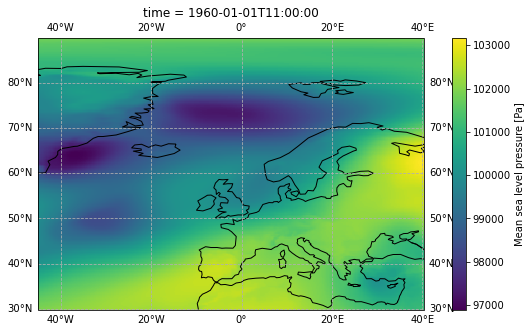

In [13]:
# plot the obs data
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
# include coastlines
ax.coastlines()

# include the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

# plot the data
obs_data["msl"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [14]:
print(udicts.eu_grid)

{'lon1': -40, 'lon2': 30, 'lat1': 30, 'lat2': 80}


In [15]:
# # set up a constant grid
# grid = {
#     "lon1": -40,
#     "lon2": 40,
#     "lat1": 30,
#     "lat2": 80,
# }

In [16]:
obs_data

<xarray.Dataset>
Dimensions:    (time: 22281, bnds: 2, longitude: 304, latitude: 214)
Coordinates:
  * time       (time) datetime64[ns] 1960-01-01T11:00:00 ... 2020-12-31T11:00:00
  * longitude  (longitude) float32 -45.0 -44.72 -44.44 ... 39.66 39.94 40.22
  * latitude   (latitude) float32 89.78 89.51 89.23 88.95 ... 30.49 30.21 29.93
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    msl        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Aug 09 11:15:43 2024: cdo daymean ERA5_msl_daily_1960_2...
    frequency:    day
    CDO:          Climate Data Operators version 2.4.1 (https://mpimet.mpg.de...

In [17]:
# subset the observed data to the correct udicts.eu_grid
obs_data = obs_data.sel(
    longitude=slice(udicts.eu_grid["lon1"], udicts.eu_grid["lon2"]),
    latitude=slice(udicts.eu_grid["lat2"], udicts.eu_grid["lat1"]),
)

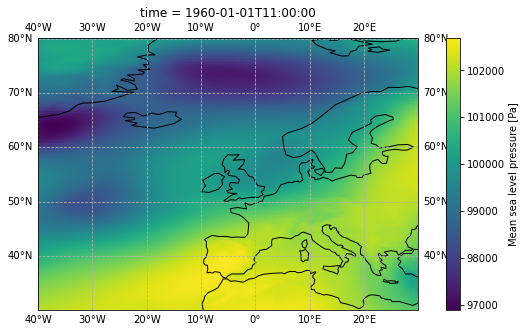

In [18]:
# plot the obs data
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
# include coastlines
ax.coastlines()

# include the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

# plot the data
obs_data["msl"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [19]:
# subset the model data to the same udicts.eu_grid
model_data = model_data.sel(
    lon=slice(udicts.eu_grid["lon1"], udicts.eu_grid["lon2"]),
    lat=slice(udicts.eu_grid["lat1"], udicts.eu_grid["lat2"]),
)

In [20]:
model_data

<xarray.Dataset>
Dimensions:                        (lead: 30, init: 1, member: 10, lat: 90,
                                    lon: 84)
Coordinates:
  * lead                           (lead) int64 1 2 3 4 5 6 ... 26 27 28 29 30
  * init                           (init) int64 1960
  * member                         (member) object 'r5i1p1f2' ... 'r10i1p1f2'
  * lat                            (lat) float64 30.28 30.83 ... 79.17 79.72
  * lon                            (lon) float64 -39.58 -38.75 ... 28.75 29.58
Data variables:
    __xarray_dataarray_variable__  (init, member, lead, lat, lon) float64 ...

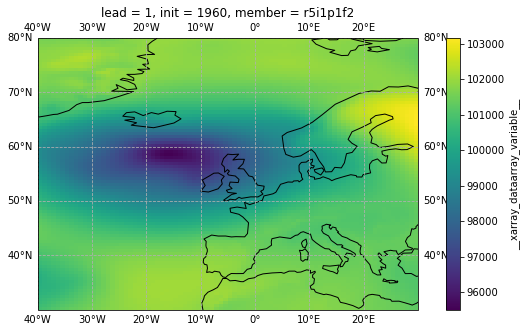

In [21]:
# plot the model data
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# include coastlines
ax.coastlines()

# include the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

# plot the data
model_data["__xarray_dataarray_variable__"].isel(member=0, lead=0).plot(ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [22]:
# convert model data to iris cubes
selected_member = model_data['__xarray_dataarray_variable__'].sel(member='r10i1p1f2')

In [23]:
# rename the variable
selected_member = selected_member.rename('sfcWind')

In [24]:
# convert to iris cube
member_cube = selected_member.squeeze().to_iris()

In [25]:
member_cube

<iris 'Cube' of sfcWind / (unknown) (lead: 30; lat: 90; lon: 84)>

In [26]:
# rename lat and lon
member_cube.coord('lat').rename('latitude')
member_cube.coord('lon').rename('longitude')

In [27]:
# # use iris to regrid the obs data to the same grid asthe model data
# # convert obs data to a cube from xarray
obs_cube = cubes_from_xarray(obs_data)

In [28]:
# make cure the units match
member_cube.coord("latitude").units = obs_cube[0].coord("latitude").units
member_cube.coord("longitude").units = obs_cube[0].coord("longitude").units

# and for the attributes
member_cube.coord("latitude").attributes = obs_cube[0].coord("latitude").attributes
member_cube.coord("longitude").attributes = obs_cube[0].coord("longitude").attributes

In [29]:
# regrid the si10 obs cube
obs_cube_regrid = obs_cube[0].regrid(member_cube, iris.analysis.Linear())

In [69]:
obs_cube_regrid

<iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (time: 22281; latitude: 90; longitude: 84)>

In [30]:
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt

In [31]:
# select first time of iris cube
obs_cube_regrid_first = obs_cube_regrid[0]

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2058: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2058: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


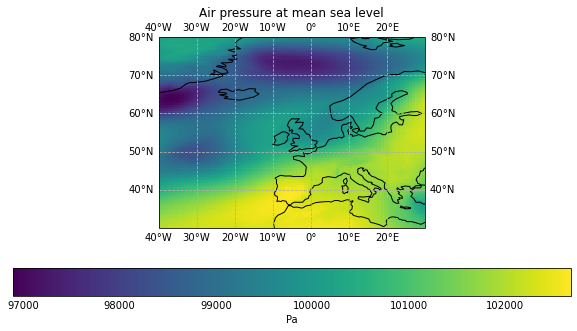

In [32]:
# plot the regridded obs data
fig = plt.figure(figsize=(10, 5))

ax = plt.axes(projection=ccrs.PlateCarree())
# include coastlines
ax.coastlines()

# include the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

# plot the data
qplt.pcolormesh(obs_cube_regrid_first, cmap='viridis')
plt.show()

In [33]:
# # set up the single file
# single_file = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r1i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_19601101-19601230.nc"

# # load the single file using iris
# model_ex_cube = iris.load_cube(single_file)

In [34]:
model_data["__xarray_dataarray_variable__"]

<xarray.DataArray '__xarray_dataarray_variable__' (init: 1, member: 10,
                                                   lead: 30, lat: 90, lon: 84)>
[2268000 values with dtype=float64]
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * init     (init) int64 1960
  * member   (member) object 'r5i1p1f2' 'r9i1p1f2' ... 'r1i1p1f2' 'r10i1p1f2'
  * lat      (lat) float64 30.28 30.83 31.39 31.94 ... 78.06 78.61 79.17 79.72
  * lon      (lon) float64 -39.58 -38.75 -37.92 -37.08 ... 27.92 28.75 29.58

In [35]:
import re

In [36]:
model_data['member'] = model_data['member'].str[1:-6].astype(int)


In [37]:
model_data_var = model_data['__xarray_dataarray_variable__']

In [38]:
# rename the variable as sfcWind
model_data_var = model_data_var.rename('sfcWind')

In [39]:
# convert to iris cube
model_cube = model_data_var.squeeze().to_iris()

In [40]:
model_cube.shape

(10, 30, 90, 84)

In [41]:
model_cube

<iris 'Cube' of sfcWind / (unknown) (-- : 10; lead: 30; lat: 90; lon: 84)>

Loop over the model cube for each init, member, lead and find the obs day with the closest value of NAO.

In [42]:
# For the observations, create a dataframe with the NAO values for each day of the observations
# subset obs cube regrid to the first 5 years
obs_cube_regrid_first_5_years = obs_cube_regrid.extract(iris.Constraint(time=lambda cell: cell.point.year < 1965))

In [43]:
# constrain to only months Oct through March
obs_cube_regrid_first_5_years = obs_cube_regrid_first_5_years.extract(iris.Constraint(time=lambda cell: cell.point.month in [10, 11, 12, 1, 2, 3]))

In [44]:
# print the latitude values
print(obs_cube_regrid_first_5_years.coord("latitude").points)

[30.27778687 30.83334247 31.38889806 31.94445366 32.50000926 33.05556486
 33.61112045 34.16667605 34.72223165 35.27778725 35.83334284 36.38889844
 36.94445404 37.50000964 38.05556523 38.61112083 39.16667643 39.72223203
 40.27778762 40.83334322 41.38889882 41.94445442 42.50001002 43.05556561
 43.61112121 44.16667681 44.72223241 45.277788   45.8333436  46.3888992
 46.9444548  47.50001039 48.05556599 48.61112159 49.16667719 49.72223278
 50.27778838 50.83334398 51.38889958 51.94445517 52.50001077 53.05556637
 53.61112197 54.16667756 54.72223316 55.27778876 55.83334436 56.38889995
 56.94445555 57.50001115 58.05556675 58.61112234 59.16667794 59.72223354
 60.27778914 60.83334473 61.38890033 61.94445593 62.50001153 63.05556712
 63.61112272 64.16667832 64.72223392 65.27778951 65.83334511 66.38890071
 66.94445631 67.5000119  68.0555675  68.6111231  69.1666787  69.72223429
 70.27778989 70.83334549 71.38890109 71.94445669 72.50001228 73.05556788
 73.61112348 74.16667908 74.72223467 75.27779027 75.

In [45]:
print(obs_cube_regrid_first_5_years.coord("longitude").points)

[-39.58334128 -38.750008   -37.91667471 -37.08334142 -36.25000814
 -35.41667485 -34.58334157 -33.75000828 -32.91667499 -32.08334171
 -31.25000842 -30.41667514 -29.58334185 -28.75000856 -27.91667528
 -27.08334199 -26.2500087  -25.41667542 -24.58334213 -23.75000885
 -22.91667556 -22.08334227 -21.25000899 -20.4166757  -19.58334242
 -18.75000913 -17.91667584 -17.08334256 -16.25000927 -15.41667598
 -14.5833427  -13.75000941 -12.91667613 -12.08334284 -11.25000955
 -10.41667627  -9.58334298  -8.7500097   -7.91667641  -7.08334312
  -6.25000984  -5.41667655  -4.58334326  -3.75000998  -2.91667669
  -2.08334341  -1.25001012  -0.41667683   0.41665645   1.24998974
   2.08332302   2.91665631   3.7499896    4.58332288   5.41665617
   6.24998945   7.08332274   7.91665603   8.74998931   9.5833226
  10.41665589  11.24998917  12.08332246  12.91665574  13.74998903
  14.58332232  15.4166556   16.24998889  17.08332217  17.91665546
  18.74998875  19.58332203  20.41665532  21.24998861  22.08332189
  22.916655

In [46]:
# define dictionaries for the NAO regions
azores_gridbox = {
    "lat1": 36,
    "lat2": 40,
    "lon1": -40,
    "lon2": -36,
}

iceland_gridbox = {
    "lat1": 63,
    "lat2": 70,
    "lon1": -25,
    "lon2": -16,
}

In [47]:
# quantify the NAO as the difference in the mean sea level pressure between the Azores and Iceland
# take the mean over the gridboxes for the Azores and Iceland
obs_cube_5_azores_clim = obs_cube_regrid_first_5_years.intersection(
    latitude=(azores_gridbox["lat1"], azores_gridbox["lat2"]),
    longitude=(azores_gridbox["lon1"], azores_gridbox["lon2"]),
).collapsed(["latitude", "longitude"], iris.analysis.MEAN).collapsed("time", iris.analysis.MEAN)

obs_cube_5_iceland_clim = obs_cube_regrid_first_5_years.intersection(
    latitude=(iceland_gridbox["lat1"], iceland_gridbox["lat2"]),
    longitude=(iceland_gridbox["lon1"], iceland_gridbox["lon2"]),
).collapsed(["latitude", "longitude"], iris.analysis.MEAN).collapsed("time", iris.analysis.MEAN)

# calculate the psl anomalies in each region
obs_cube_5_azores_anom = obs_cube_regrid_first_5_years.intersection(
    latitude=(azores_gridbox["lat1"], azores_gridbox["lat2"]),
    longitude=(azores_gridbox["lon1"], azores_gridbox["lon2"]),
).collapsed(["latitude", "longitude"], iris.analysis.MEAN) - obs_cube_5_azores_clim

obs_cube_5_iceland_anom = obs_cube_regrid_first_5_years.intersection(
    latitude=(iceland_gridbox["lat1"], iceland_gridbox["lat2"]),
    longitude=(iceland_gridbox["lon1"], iceland_gridbox["lon2"]),
).collapsed(["latitude", "longitude"], iris.analysis.MEAN) - obs_cube_5_iceland_clim

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/cube.py:3859: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/i

In [48]:
# calculate the NAO index as azores - iceland
obs_cube_5_nao = obs_cube_5_azores_anom - obs_cube_5_iceland_anom

In [49]:
# extract the NAO values
nao_values = obs_cube_5_nao.data / 100

# extract the time values
time_values = obs_cube_5_nao.coord("time").points

# create a dataframe with the NAO values
nao_df = pd.DataFrame(
    {
        "time": time_values,
        "nao": nao_values,
    }
)

In [50]:
nao_df

,time,nao
0,525947,15.332656
1,525971,3.034844
2,525995,21.990469
3,526019,34.376408
4,526043,9.471562
...,...,...
907,569675,-1.483047
908,569699,7.611406
909,569723,22.065859
910,569747,12.436328


In [51]:
model_cube

<iris 'Cube' of sfcWind / (unknown) (-- : 10; lead: 30; lat: 90; lon: 84)>

In [53]:
# rename lat and lon to proper names
model_cube.coord('lat').rename('latitude')
model_cube.coord('lon').rename('longitude')

# set the units of the 'latitude' and 'longitude' coordinates to degrees
model_cube.coord('latitude').units = 'degrees'
model_cube.coord('longitude').units = 'degrees'

In [60]:
# set up an empty dataframe to store the values
nao_df_model = pd.DataFrame()

print("nao_df_model type: ", type(nao_df_model))

# Now do the same but for the model data
# loop over the lead times in the model data
for lead in model_cube.coord("lead").points:
    # now loop over the members
    for member in model_cube.coord("member").points:
        # print(f"lead: {lead}, member: {member}")

        # subset the model data to the current lead and member
        model_cube_subset = model_cube.extract(iris.Constraint(lead=lead, member=member))

        # set up the model cube member
        model_cube_member = model_cube.extract(iris.Constraint(member=member))

        # calculate azores psl anoms
        model_cube_azores_anom = model_cube_subset.intersection(
            latitude=(azores_gridbox["lat1"], azores_gridbox["lat2"]),
            longitude=(azores_gridbox["lon1"], azores_gridbox["lon2"]),
        ).collapsed(["latitude", "longitude"], iris.analysis.MEAN) - model_cube_member.intersection(
            latitude=(azores_gridbox["lat1"], azores_gridbox["lat2"]),
            longitude=(azores_gridbox["lon1"], azores_gridbox["lon2"]),
        ).collapsed(["latitude", "longitude"], iris.analysis.MEAN).collapsed("lead", iris.analysis.MEAN)

        # calculate iceland psl anoms
        model_cube_iceland_anom = model_cube_subset.intersection(
            latitude=(iceland_gridbox["lat1"], iceland_gridbox["lat2"]),
            longitude=(iceland_gridbox["lon1"], iceland_gridbox["lon2"]),
        ).collapsed(["latitude", "longitude"], iris.analysis.MEAN) - model_cube_member.intersection(
            latitude=(iceland_gridbox["lat1"], iceland_gridbox["lat2"]),
            longitude=(iceland_gridbox["lon1"], iceland_gridbox["lon2"]),
        ).collapsed(["latitude", "longitude"], iris.analysis.MEAN).collapsed("lead", iris.analysis.MEAN)

        # calculate the NAO index
        model_cube_nao = model_cube_azores_anom - model_cube_iceland_anom

        # extract the NAO values
        nao_values = model_cube_nao.data

        # # print the lead and its type
        # print(f"lead: {lead}, type: {type(lead)}")
        # print(f"member: {member}, type: {type(member)}")
        # print(f"nao_values: {nao_values}, type: {type(nao_values)}")

        # create a dataframe with the values
        nao_df_model_subset = pd.DataFrame(
            {
                "lead": [lead],
                "member": [member],
                "nao": nao_values.flatten(),  # flatten the array to make it 1D
            }
        )

        # # print the type of the nao_df_model_subset
        # print("nao_df_model_subset type: ", type(nao_df_model_subset))

        # # print the type of the nao_df_model
        # print("nao_df_model type: ", type(nao_df_model))

        # append the rows of nao_df_model_subset to nao_df_model
        nao_df_model = pd.concat([nao_df_model, nao_df_model_subset])

nao_df_model type:  <class 'pandas.core.frame.DataFrame'>


/home/users/benhutch/.local/lib/python3.10/site-packages/iris/cube.py:3859: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/i

In [61]:
nao_df_model

,lead,member,nao
0,1,5,-1041.806212
0,1,9,-122.636706
0,1,8,-33.123213
0,1,7,-777.678989
0,1,4,-1046.502027
...,...,...,...
0,30,3,-251.370672
0,30,2,1322.345254
0,30,6,49.338252
0,30,1,-207.423961


In [62]:
# divide the nao by 100 in nao_df_model
nao_df_model["nao"] = nao_df_model["nao"] / 100

In [63]:
nao_df_model.head()

,lead,member,nao
0,1,5,-10.418062
0,1,9,-1.226367
0,1,8,-0.331232
0,1,7,-7.776790
0,1,4,-10.465020


In [64]:
# set lead and member as the index
nao_df_model.set_index(["lead", "member"], inplace=True)

In [65]:
nao_df_model.head()

nao
lead member           
1    5      -10.418062
     9       -1.226367
     8       -0.331232
     7       -7.776790
     4      -10.465020

In [66]:
nao_df.head()

,time,nao
0,525947,15.332656
1,525971,3.034844
2,525995,21.990469
3,526019,34.376408
4,526043,9.471562


In [67]:
# for each column in nao_df_model, find the time in nao_df which has the closest value of nao
# to the value in nao_df_model
# set up an empty dataframe to store the values
nao_df_model_matched = pd.DataFrame()

# loop over the rows in nao_df_model
for idx, row in nao_df_model.iterrows():
    # print(f"lead: {idx[0]}, member: {idx[1]}")

    # find the time in nao_df which has the closest value of nao to the value in nao_df_model
    closest_time = nao_df.iloc[(nao_df["nao"] - row["nao"]).abs().argsort()[:1]]

    # set up a dataframe with the lead and member values and time
    closest_time["lead"] = idx[0]
    closest_time["member"] = idx[1]

    # append the closest time to nao_df_model_matched
    nao_df_model_matched = pd.concat([nao_df_model_matched, closest_time])

/tmp/ipykernel_24918/699304067.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closest_time["lead"] = idx[0]
/tmp/ipykernel_24918/699304067.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closest_time["member"] = idx[1]
/tmp/ipykernel_24918/699304067.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [68]:
nao_df_model_matched

,time,nao,lead,member
609,553739,-10.419687,1,5
661,559379,-1.263672,1,9
262,536627,-0.257656,1,8
104,532835,-7.739766,1,7
539,552059,-10.445859,1,4
...,...,...,...,...
821,567611,-2.503906,30,3
865,568667,13.228359,30,2
255,536459,0.446406,30,6
686,559979,-2.006328,30,1


In [71]:
import cftime

# Now plot the psl field for the matched time in nao_df_model_matched
# extract the specific time from obs_cube_regrid
first_row = nao_df_model_matched.iloc[0]

# extract the time
time = first_row["time"]

# convert the time variable to cftime._cftime.DatetimeGregorian
time = cftime.num2date(time, 'hours since 1900-01-01', 'gregorian')

# extract the obs cube regrid for the time
obs_cube_regrid_time = obs_cube_regrid.extract(iris.Constraint(time=time))

# extract the model data for the lead and member
lead = first_row["lead"]
member = first_row["member"]

model_cube_member_lead = model_cube.extract(iris.Constraint(lead=lead, member=member))

In [83]:
# extracts the lat and lon values
lats = obs_cube_regrid_time.coord("latitude").points
lons = obs_cube_regrid_time.coord("longitude").points
obs_field = obs_cube_regrid_time.data / 100

# extract the model field
model_field = model_cube_member_lead.data / 100

In [86]:
# print the min and max of the data
print("obs min: ", obs_field.min())
print("obs max: ", obs_field.max())

print("model min: ", model_field.min())
print("model max: ", model_field.max())

obs min:  982.2902
obs max:  1030.1344
model min:  955.056015625
model max:  1031.583359375


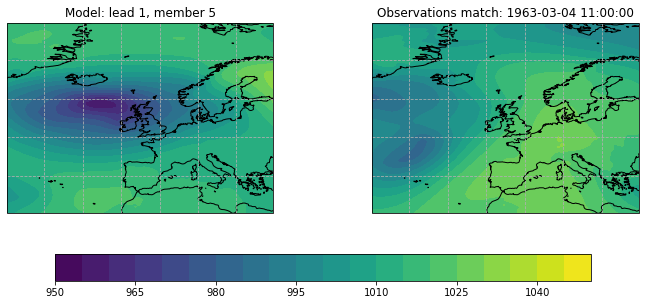

In [90]:
# plot the two fields side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# set up the contour levels
clevs = np.linspace(950, 1050, 21)

# include coastlines
axs[0].coastlines()

# include the gridlines
gl = axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle="--")

# set the title
axs[0].set_title(f"Model: lead {int(lead)}, member {int(member)}")

axs[0].contourf(lons, lats, model_field, clevs, transform=ccrs.PlateCarree(), cmap='viridis')

# include coastlines
axs[1].coastlines()

# include the gridlines
gl = axs[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle="--")

# Observations match
axs[1].set_title(f"Observations match: {time}")

myplot = axs[1].contourf(lons, lats, obs_field, clevs, transform=ccrs.PlateCarree(), cmap='viridis')

# # add a colorbar
cbar = plt.colorbar(myplot, ax=axs, orientation='horizontal', shrink=0.8)

Not quite close enough - should use the psl field difference as well (or instead of?)

Then loop over the model cube, for each init, member, lead, find the obs day (date) with the smallest absolute difference for the si10 field (for regridded obs). Come up with a list of dates to be extracted from the observations and then see whether this produces a semi-realistic time series.